#### Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

#### Loading Data

In [ ]:
import zipfile

# Define the path to your ZIP file and the extraction path
zip_path = "/content/drive/MyDrive/flickr8k.zip"
extract_path = "/content/flickr8k"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")

Dataset unzipped successfully!


In [ ]:
image_path = '/content/flickr8k/images'

In [ ]:
data = pd.read_csv("/content/flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


#### Image Reading and Display

In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/flickr8k/images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

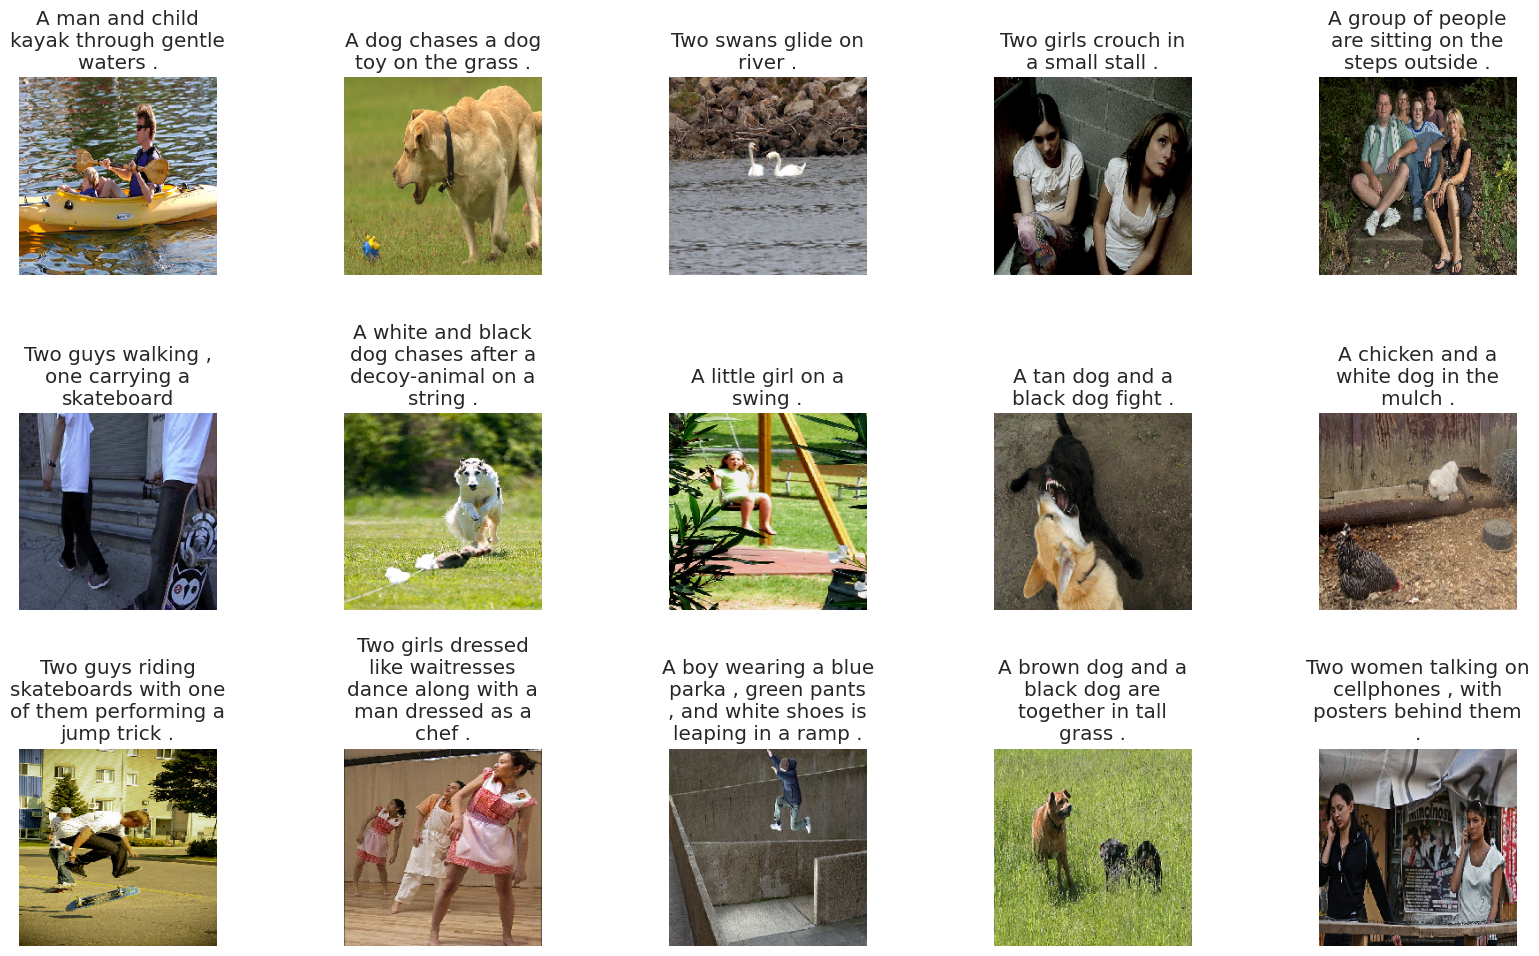

In [ ]:
display_images(data.sample(15))

#### Text Preprocessing

Cleaning Captions

This cleaning function prepare caption by converting text to lowercase,removing unwanted characters,standarding spaces,adding sequence tags.This preprocessing improve the quality and consistence of the text data,making it more sutiable for training and analysis.

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower()) #Converts all characters in the caption to lowercase.
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]","")) #Removes any non-alphabetic characters
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," ")) #Replaces multiple spaces with a single space.
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1])) #Removes single-character words from the captions
    data['caption'] = "startseq "+data['caption']+" endseq" # Adds special tokens
    return data

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

####  Tokenizing Text

In [ ]:
# tokenizing text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1 #The +1 is added because neural networks sometimes need an additional token to handle padding or out-of-vocabulary words.
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

#### Feature Extraction

Feature extraction involves transforming raw data into meaningful, compact representations for machine learning or deep learning tasks.

Here we use pre-trained VGG16 model which is composed of 16 layers,13 convolutional layers and 3 fully connected layers.It employed for extracting high-level image features.

Process:

1. Image Loading: Images are loaded and resized to the input dimensions required by the model (224x224 pixels).
2. Preprocessing: Images are converted into arrays and normalized using preprocess_input for compatibility with the VGG16 model.
3. Feature Extraction: The images are passed through the pre-trained VGG16 model (without the top classification layers), and features are extracted from the final convolutional layer.
4. Flattening: The extracted features are flattened into a 1D array for efficient storage and further analysis.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Load VGG16 without the top classification layers
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
fe = Model(inputs=base_model.input, outputs=base_model.output)

features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # Preprocess input specific to VGG16
    feature = fe.predict(img, verbose=0)
    features[image] = feature.flatten()  # Flatten the feature map


100%|██████████| 8091/8091 [10:19<00:00, 13.06it/s]


In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        return X1, X2, y

#### Model Architecture

Input Layers:

input1:

*   input1: Features from the image, reshaped to a vector of size 7x7x512.
*   input2: Tokenized text input, representing the caption (with max length)

Image Feature Processing:
*   A fully connected layer (Dense) is applied to input1 to reduce dimensionality to 256.
*   The output is reshaped to (1, 256).

Text Feature Processing:

*   The text input (input2) is passed through an embedding layer, converting words into dense vectors of size 256.

Feature Fusion:

*   Image features and sentence features are concatenated along the axis 1 (sequence + image).

Sequence Modeling:
*   A Long Short-Term Memory (LSTM) layer processes the combined features to capture temporal dependencies in the sequence.
Fusion with Image Features:
*   Dropout (0.5) is applied to the LSTM output, followed by a skip connection that adds the original image features.

Fully Connected Layers:

*   A dense layer of 128 units and ReLU activation is followed by another dropout layer.
*   Final output layer uses softmax activation to predict the next word in the sequence.
Compilation:  
*   The model is compiled using categorical cross-entropy loss and Adam optimizer.

In [ ]:
input1 = Input(shape=(25088,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
caption_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 25088)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 256)            │      6,422,784 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_10            │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 1, 256)         │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 34, 256)        │      2,172,160 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 35, 256)        │              0 │ reshape_3[0][0],       │
│ (Concatenate)             │                        │                │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 256)            │        525,312 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 256)            │              0 │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 256)            │              0 │ dropout_6[0][0],       │
│                           │                        │                │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 128)            │         32,896 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 128)            │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 8485)           │      1,094,565 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,247,717 (39.09 MB)

 Trainable params: 10,247,717 (39.09 MB)

 Non-trainable params: 0 (0.00 B)

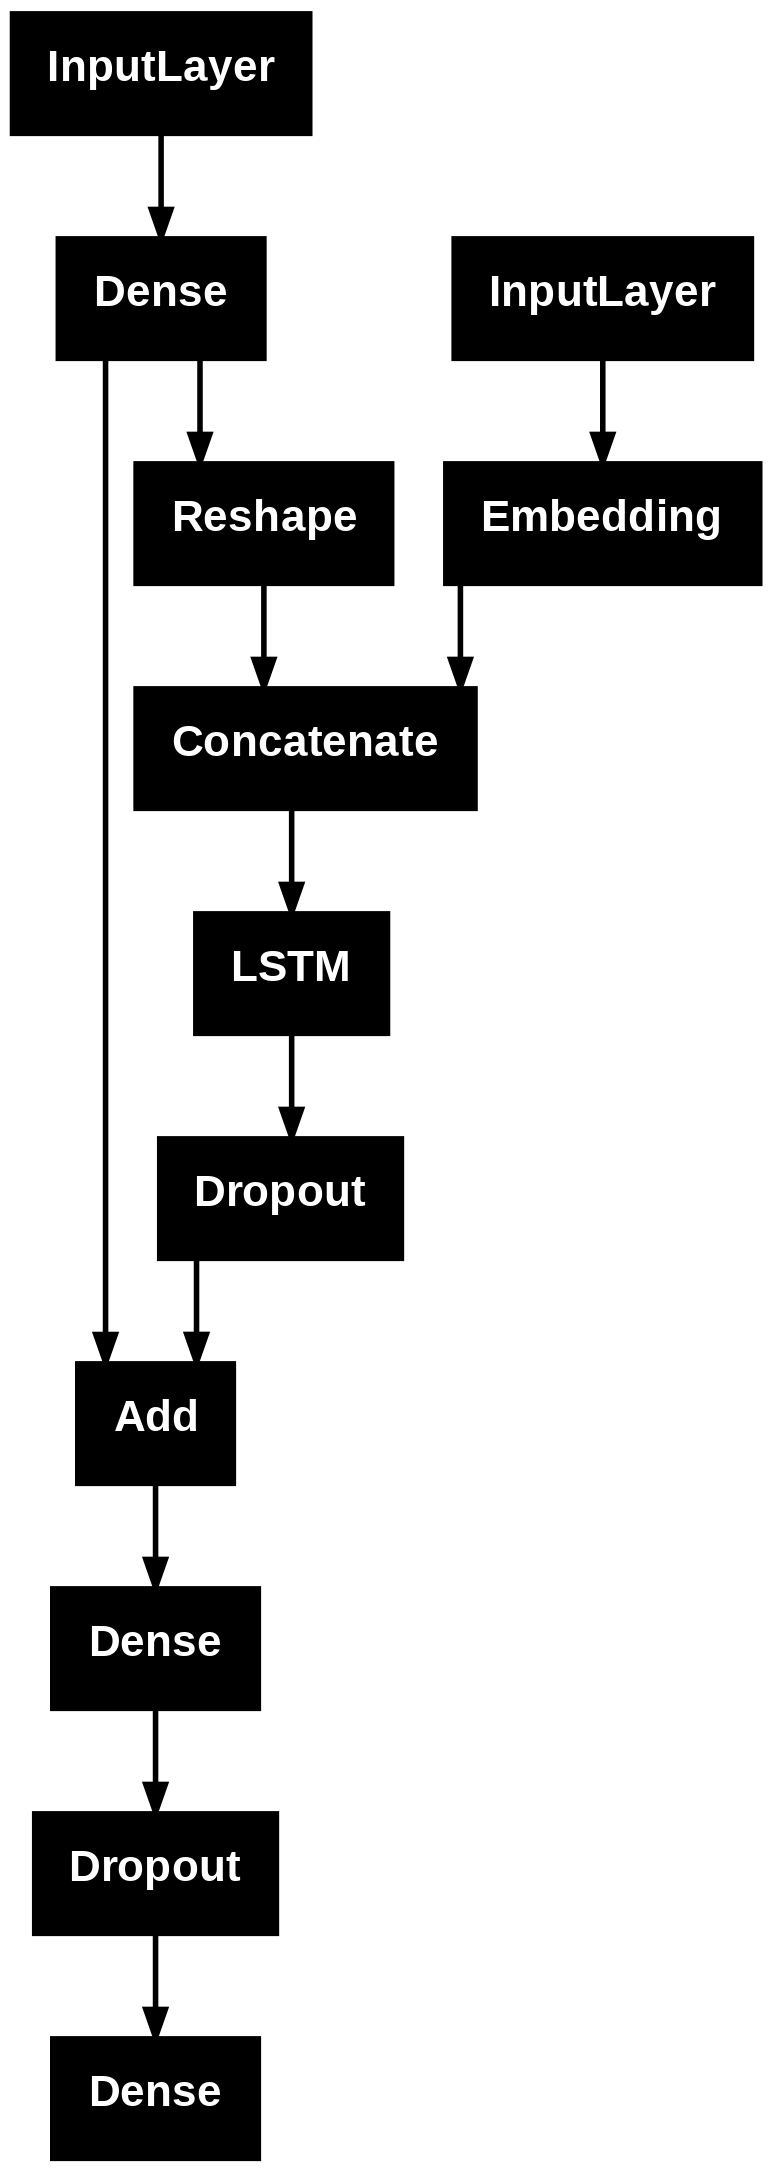

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model)

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

#### Training the Model

Here we trains the model over a series using a train generator to efficiently handle large dataset.The model updates its weights based on the data provided by the generator, improving its performance on the task

In [ ]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 4.9500
Epoch 1: val_loss improved from 4.92211 to 4.40610, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 142s 262ms/step - loss: 4.9498 - val_loss: 4.4061 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 4.5678
Epoch 2: val_loss improved from 4.40610 to 4.25183, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 137s 252ms/step - loss: 4.5677 - val_loss: 4.2518 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 4.3661
Epoch 3: val_loss improved from 4.25183 to 4.14513, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 137s 253ms/step - loss: 4.3660 - val_loss: 4.1451 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 4.2462
Epoch 4: val_loss improved from 4.14513 to 4.07397, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 138s 255ms/step - loss: 4.2462 - val_loss: 4.0740 - learning_rate:

#### Evaluating Model Performance

The BLEU (Bilingual Evaluation Understudy) score is used to evaluate the quality of generated caption by comparing them to reference caption.The `corpus_bleu` function from NLTK compute this metric for a set of predicted captions against actual captions.

This process evaluates the performance of a captioning model by calculating BLEU scores, which quantify how well the generated captions match reference captions.The BLEU-1 and BLEU-2 score specifically measure the precision of single words and word pair,respectively.

---



In [ ]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Define the prediction function using the model
def predict_caption(model, image_feature, tokenizer, max_length):
    in_text = "startseq"  # Start token
    image_feature = np.expand_dims(image_feature, axis=0)
    for i in range(max_length):
        # Tokenize the input text
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Predict the next word
        yhat = model.predict([image_feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        # Map integer to word
        word = {value: key for key, value in tokenizer.word_index.items()}.get(yhat)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    return in_text

# Loop through the test data
for _, row in tqdm(test.iterrows(), total=len(test)):
    image_id = row['image']
    actual_captions = [row['caption']]  # Actual captions for the image
    predicted_caption = predict_caption(caption_model, features[image_id], tokenizer, max_length)

    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Split predicted caption into words
    predicted_caption_words = predicted_caption.split()

    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))


100%|██████████| 6070/6070 [53:27<00:00,  1.89it/s]


BLEU-1: 0.346918
BLEU-2: 0.163426


#### Generating Captions

The function genetate_caption is designed to:
1. Load an image from the file system.
2. Retrive and display actual captions associated with the image.
3. Generate and display a predicted caption for the image using a trained model.
4. Display the image.

This function provides a comprehensive view of how well the model performs by comparing actual and predicted captions for a given images.It also visually display the image to facilitate better understanding of the generated captions.

In [ ]:
# Function for generating caption
def generate_caption(image_name):
    # Load the image
    image_id = image_name  # Use image_name as the key for lookup in features
    img_path = f"/content/flickr8k/images/{image_name}"

    # Open and display the image
    image = load_img(img_path, target_size=(img_size, img_size))  # Use the same img_size from earlier
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    # Retrieve all actual captions for the image
    actual_captions = train[train['image'] == image_name]['caption'].tolist()  # Adjusted to retrieve from the correct DataFrame

    if len(actual_captions) == 0:
        print("No actual captions found for this image in the dataset!")
    else:
        print('---------------------Actual---------------------')
        for caption in actual_captions:
            print(caption)

    # Predict the caption
    if image_id not in features:
        print("Feature for this image not found!")
        return

    predicted_caption = predict_caption(caption_model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(predicted_caption)


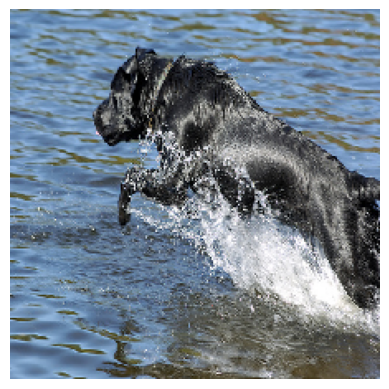

---------------------Actual---------------------
startseq black dog is running in the water endseq
startseq black dog running into the water endseq
startseq black dog running through water endseq
startseq black dog runs through the water endseq
startseq black dog splashes through water endseq
--------------------Predicted--------------------
startseq black dog is running in the water endseq


In [ ]:
generate_caption('1470132731_fa416b7504.jpg')

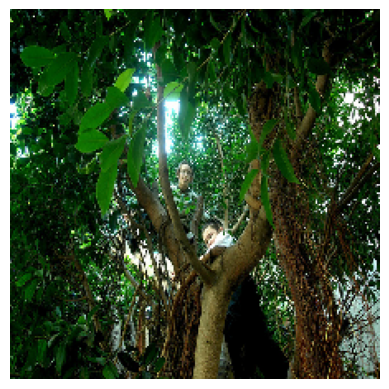

---------------------Actual---------------------
startseq children climbing huge tree endseq
startseq two children are sitting in some tree branches endseq
startseq two children look down from green tree they have climbed endseq
startseq two kids in green tree endseq
startseq two people standing in tree on sunny day endseq
--------------------Predicted--------------------
startseq two children are standing on tree endseq


In [ ]:
generate_caption('1808504612_3508f3c9bb.jpg')

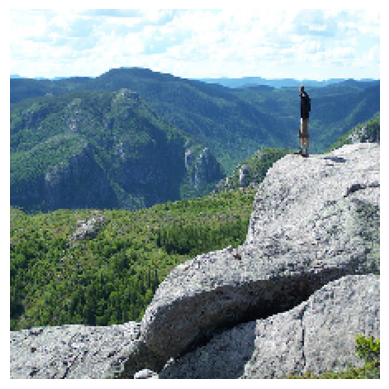

---------------------Actual---------------------
startseq lone man stands on rocky outcropping and looks out over the wilderness endseq
startseq man in shorts and black jacket stands on top of big rock looking down on hills and valleys endseq
startseq man is standing on big rock overlooking valley endseq
startseq man stands atop large mountain of rocks endseq
startseq man standing on edge of large rock overlooking scenic view endseq
--------------------Predicted--------------------
startseq man is standing on rock endseq


In [ ]:
generate_caption('1579287915_4257c54451.jpg')

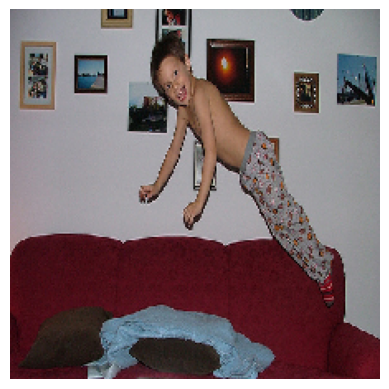

---------------------Actual---------------------
startseq boy in grey pajamas is jumping on the couch endseq
startseq boy in pajama pants jumps on red couch endseq
startseq boy smiles at the camera and jumps in the air over the couch endseq
startseq shirtless boy jumps onto the couch endseq
startseq the boy in pajama pants jumps off the sofa endseq
--------------------Predicted--------------------
startseq boy is jumping onto the bed endseq


In [ ]:
generate_caption('2081679622_6f1442367d.jpg')

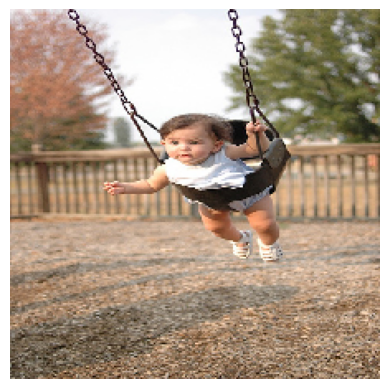

---------------------Actual---------------------
startseq baby swings in swing near wooden fence endseq
startseq baby wearing all white swinging on swing endseq
startseq little girl is swinging in baby swing on the playground endseq
startseq little girl rides in child 's swing endseq
startseq young baby girl wearing white outfit swinging in baby swing endseq
--------------------Predicted--------------------
startseq little boy is swinging on swing endseq


In [ ]:
generate_caption('1332815795_8eea44375e.jpg')